# Импорт библиотек

In [1]:
import numpy as np
from gzip import open # NB: overrides standard open()
import pickle as pkl
import pandas as pd
import warnings 
from glob import glob
import os
import math
import functools

In [2]:
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
from numpy import linalg as LA

In [6]:
from sklearn.metrics import r2_score

In [7]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### Отключим предупреждения Anaconda

In [8]:
warnings.simplefilter('ignore')

# Загрузим данные

In [93]:
Xdata_numpy = pkl.load(open('train.pkl.gz', 'rb'))
#Ydata = pkl.load(open('y.pkl.gz', 'rb'))

In [94]:
# C:/Users/admin/Desktop/PLS_continue_2020/
# Сохранил чисто для себя на случай, если вновь что-то не получится

# N-PLS1

# Приближение к правильному алгоритму

 ### Опишу ка я центрирование в виде класса, для удобства.

In [95]:
#y.iloc[:,self.column_y].to_numpy()

In [96]:
class centrir(BaseEstimator):
    """"Этот класс производит центрирование, а потом из центрированных данных переходит обратно"""
    def  __init__(self, testSize=2*0.02857, column_y=0):
        self.testSize = testSize
        self.column_y=column_y
    
    
    def centering_and_cv(self,xx,yy,xtt,ytt):
        x=xx.copy()
        y=yy.copy()
        xt=xtt.copy()
        yt=ytt.copy()
        x_centrir=np.array(x)
        y_centrir=np.array(y)
        xt=np.array(xt)
        yt=np.array(yt)
        xt-=x_centrir.mean(axis = 0)
        x_centrir -= x_centrir.mean(axis = 0)
        self.medium=y_centrir.mean() #Это сренее значение у.
        yt-=y_centrir.mean()
        y_centrir -= y_centrir.mean()
        
        #X_train, X_test, y_train, y_test = train_test_split(
                #x_centrir, y_centrir, test_size=self.testSize 
                #)
        self.X_train=x_centrir
        self.X_test=xt
        self.y_train=y_centrir
        self.y_test=yt
        return self
    
    def recentering(self,yy):
            y=yy.copy()
            y+=self.medium
            return y
        
    

### Переделаю класс с учётом твоих замечаний и так, чтобы его можно было загнать в GridSearchCV

In [97]:
class Tri_PLS1_grid(RegressorMixin,BaseEstimator):
    def  __init__(self, n_components=2):
        self.n_components = n_components
        
            
    def fit(self, xx, yy):
        """Fits the model to the data (X, y)

        Parameters
        ----------
        X : ndarray
        y : 1D-array of shape (n_samples, )
            labels associated with each sample"""
        x=xx.copy()
        y=yy.copy()        
        Tt=np.zeros([x.shape[0],self.n_components])
        mass=np.zeros([y.shape[0]])
        y_copy=yy.copy()
        """"
        При различных способах разрезания исходных данных, массивы w_k и w_i имеют похожие значения и именно их я планирую 
        использовать для функции predict данного класса. """
        w_k_mass=np.zeros([self.n_components,x.shape[1],1])
        w_i_mass=np.zeros([self.n_components,x.shape[2],1])
        bf_array=[]
        for f in range(0,self.n_components):
            z=np.zeros([x.shape[1],x.shape[2]])
            x_product=np.zeros([x.shape[0],x.shape[1],x.shape[2]])
            for i in range(0,x.shape[0]):
                x_product[i,:,:]=x[i,:,:]*y[i]
            z=x_product.sum(axis=0)
            Wk, S, WI = np.linalg.svd(z)
            w_k=np.array(Wk[0,:]).reshape(x.shape[1],1)
            w_i=np.array(WI[0,:]).reshape(x.shape[2],1)
            w_k_mass[f,:,:]=w_k
            w_i_mass[f,:,:]=w_i
            
            for h in range(0,x.shape[0]):
                 Tt[h,f]=np.dot(np.dot(w_k.transpose(),x[h,:,:]),w_i)
            T=np.array(Tt[:,0:f+1]).reshape(x.shape[0],f+1)
            bf=np.dot(np.dot(np.linalg.inv(np.dot(T.transpose(),T)),T.transpose()),y)
            bf_array+=[bf]
            mmas=np.kron(Tt[:,f],np.kron(w_i,w_k).reshape(x.shape[1],x.shape[2])).reshape(x.shape[0],x.shape[1],x.shape[2])
            x=x-(mmas)             
            y=y-(np.dot(T,bf))
            mass+=np.dot(T,bf)   
        self.bf_array=bf_array
        self.train_error=mean_squared_error(mass,y_copy)
        self.w_k=w_k_mass
        self.w_i=w_i_mass
        
        return self
    
    

    def predict(self, xx):
        x=xx.copy()
        xn=x.reshape(x.shape[0],x.shape[1]*x.shape[2])
        wk=np.array(self.w_k[0,:,:]).reshape(x.shape[1],1)
        wj=np.array(self.w_i[0,:,:]).reshape(x.shape[2],1)
        ww=np.kron(wk,wj).reshape(xn.shape[1])
        R=np.zeros([xn.shape[1],self.n_components])
        t=np.zeros([self.n_components,x.shape[0]])
        R[:,0]=ww.reshape(xn.shape[1])
        t[0,:]=np.dot(xn.copy(),ww).reshape(x.shape[0])
        I=np.eye(xn.shape[1])
        P=np.eye(xn.shape[1])
        p=np.ones([xn.shape[1]])
        B=np.zeros([self.n_components,self.n_components])
        for j in range(0,self.n_components):
            num=0
            for i in self.bf_array[j]:
                B[j,num]=i
                num+=1
        B=np.array([B]).reshape(self.n_components,self.n_components)
        b=B.sum(axis=0)
        kp=np.zeros([xn.shape[1]])
        for f in range(0,self.n_components-1):
            w=np.zeros([xn.shape[1]])
            w=np.kron(np.array(self.w_k[f,:,:]).reshape(x.shape[1],1),
                      np.array(self.w_i[f,:,:]).reshape(x.shape[2],1)
                     ).reshape(xn.shape[1])
            w_p=np.zeros([xn.shape[1]])
            w_p=np.kron(np.array(self.w_k[f+1,:,:]).reshape(x.shape[1],1),
                        np.array(self.w_i[f+1,:,:]).reshape(x.shape[2],1)
                       ).reshape(xn.shape[1])
            P=I-np.kron(w if f == 0 
                        else kp, w.transpose()).reshape(xn.shape[1], xn.shape[1])
            kp=np.dot(P,w_p).reshape(xn.shape[1])
            
            
            t[f+1,:]=np.dot(xn.copy(),kp.copy()).reshape(x.shape[0])
            R[:,f+1]=kp.reshape(xn.shape[1])
        
        b_pls1=np.dot(R,b).reshape(xn.shape[1])
        y=np.dot(xn,b_pls1).reshape(x.shape[0])
       
        return y

### Зделаю ка я применение двух предыдущих классов тоже в виде класса

In [98]:
class run_class(RegressorMixin,BaseEstimator):
    def  __init__(self, testSize=0.1428, column_y=0, components_array=range(1,17), number_vallidations=5):
        self.testSize = testSize
        self.column_y=column_y
        self.components_array = components_array
        self.number_vallidations=number_vallidations
        
    def data_centerng(self,x,y,xt,yt):
        data=centrir(testSize=self.testSize, column_y=self.column_y)
        self.data_cv=data.centering_and_cv(x.copy(),y.copy(),xt.copy(),yt.copy())
        return self
    
    def cv(self):
        train_error=np.zeros([len(self.components_array)])
        test_error=np.zeros([len(self.components_array)])
        p_error=np.zeros([len(self.components_array)])
        n=0
        for i in self.components_array:
            regressioModel=Tri_PLS1_grid()
            parametrsNames={ 
                'n_components': [i]
            }

            gridCought=GridSearchCV(regressioModel, parametrsNames, cv=self.number_vallidations, return_train_score=True)
            gridCought.fit(self.data_cv.X_train.copy(),self.data_cv.y_train.copy())
            train_error[n]=gridCought.cv_results_[ "mean_train_score"]
            test_error[n]=gridCought.cv_results_[ "mean_test_score" ]
            p_error[n]=gridCought.score(self.data_cv.X_test.copy(),self.data_cv.y_test.copy())
            n+=1
        self.train_error=train_error
        self.test_error=test_error
        self.p_error=p_error
        plt.figure(figsize=(12,14))
        plt.plot(train_error,".", color="red")
        plt.plot(test_error,".", color="blue")
        plt.plot(p_error,".", color="green")
        plt.grid()
        plt.show();
        return self

In [101]:
mod=run_class(testSize=10*0.00999,components_array=range(1,5),number_vallidations=5)

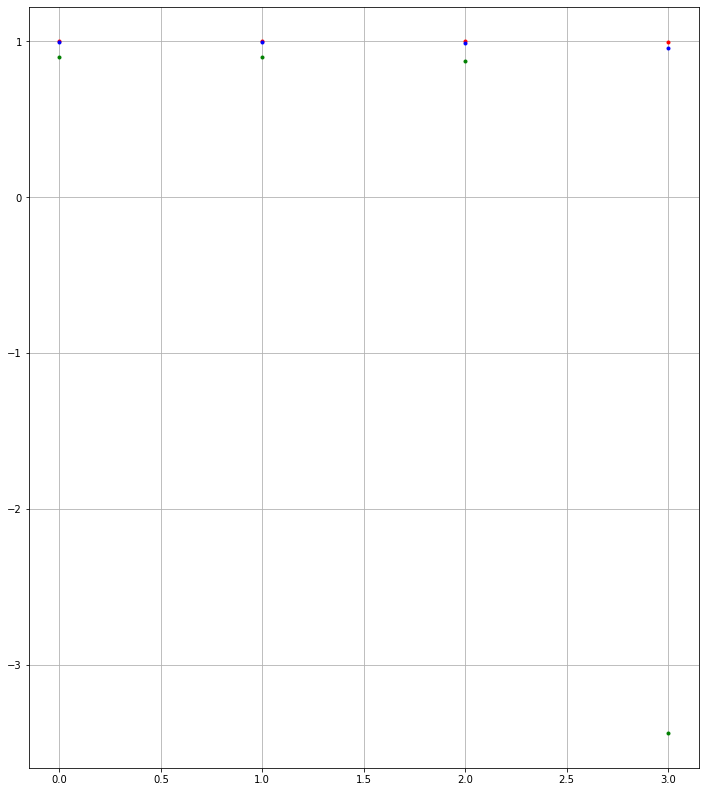

Wall time: 1.58 s


In [102]:
%%time
mod.data_centerng(Xdata_numpy["X"],Xdata_numpy["y"],Xdata_numpy["x_test"],Xdata_numpy["y_test"])
result=mod.cv()

In [103]:
result.test_error

array([0.99696639, 0.99637186, 0.99105166, 0.95426446])

In [104]:
result.p_error

array([ 0.89785591,  0.89804564,  0.87094546, -3.44002036])

In [105]:
result.train_error

array([0.99987588, 0.99985655, 0.99971169, 0.99762983])

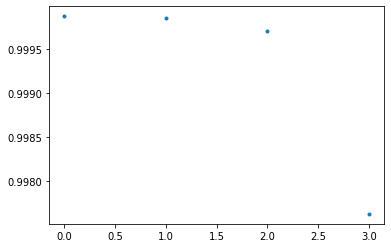

In [106]:
plt.plot(result.train_error,".")
plt.show();

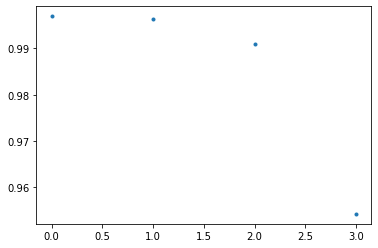

In [107]:
plt.plot(result.test_error,".")
plt.show();

In [108]:
max(result.test_error)

0.9969663937226912